Feature extraction is arguably the most important step in any data analysis process. While a number of packages exist for fitting sophisticated models, deciding the proper features to extract is still a practice that requires a keen understanding of the data and the kinds of questions one hopes to answer.

In this tutorial, we'll show how many features of interest are extracted from a single, complex, naturalistic auditory signal. The speech information comes in the form of TIMIT sentences, which are speakers of varying regional accents speaking sentences aloud. TIMIT is particularly useful because it's also well-characterized phonetically.

We'll begin with simple features, and then move towards more complicated features, all of which could be used to model brain activity.

However, before we start, we'll extract the neural features that we'll be using throughout the rest of analyses.


# Neural features
## Raw ECoG Data
Electrocorticography data is particularly useful because it allows the researcher to extract "high-frequency" amplitude. This represents the combined activity of thousands of neurons that are near the electrode's surface. Electrodes are generally ~2.5 to 5 mm diameter and have a ~1 to 2 **should I say pial/arachnoid here? seems too much** cm spacing. As a result, high-frequency amplitude is a much more spatially and temporally localized signal (compared with raw ECoG or EEG) that is well-suited to encoding/decoding models.

First off, we'll plot the raw data for this electrode:

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import FastICA, PCA
from modelingtools import delay_time_series, plot_gabors_2d
from sklearn.preprocessing import scale
from numpy.fft import fft2, fftshift, fftfreq

import warnings
warnings.simplefilter('ignore')
%matplotlib inline

/Users/choldgraf/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
raw_path = '../raw_data/'
save_path = '../features/'

In [3]:
# We'll save all timeseries data at this sampling frequency
sfreq_new = 200

In [4]:
# We'll use inline notebook plotting for interactivity here
# %matplotlib notebook

First, we'll visualize the raw ECoG electrode activity. The x-axis is time, and each horizontal line is one channel. We are plotting epochs of activity, represented by vertical sections of the plot (this can be hard to see if the signal amplitude is too large).

The start / stop of each epoch is shown with the vertical dotted lines, the green line represents `time ==0` (in this case, the onset of speech). Above each epoch is a number representing the epoch "type", which in our case is the same for all epochs. We are plotting a window from -1.5 to 6 seconds relative to stimulus onset.

Note that normally we would begin with the full (non-epoched) ECoG dataset, but we have performed this step already in order to reduce the amount of data included with the repository. We've included a larger-than-usual window around stimulus onset in order to avoid edge artifacts.

Reading ../raw_data/ecog-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1500.00 ...    5996.67 ms
        0 CTF compensation matrices available
29 matching events found
29 matching events found
0 projection items activated


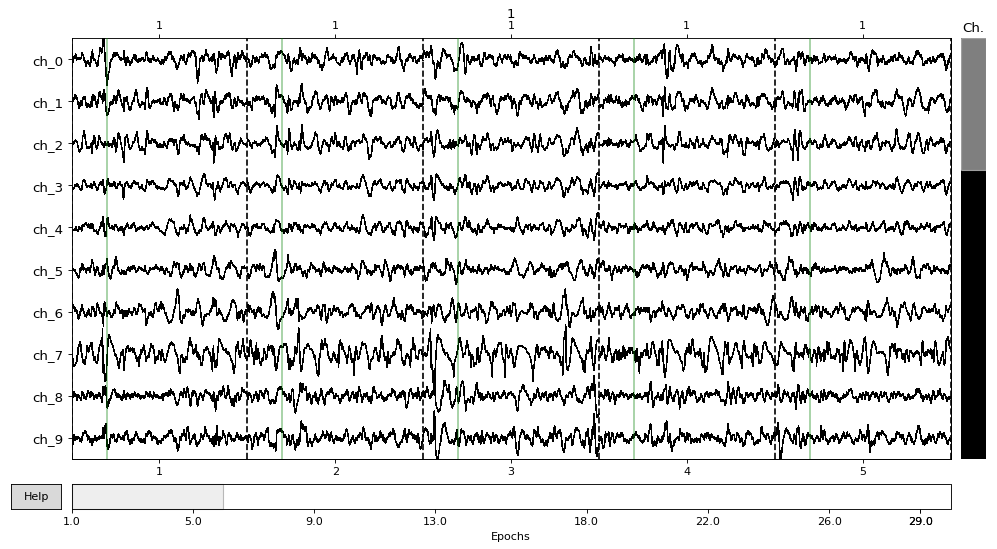

In [5]:
ecog = mne.read_epochs(raw_path + 'ecog-epo.fif', preload=True)
_ = ecog.plot(scalings='auto', n_epochs=5, n_channels=10)

The data looks a bit noisy, so we'll average across epochs (trials) just to get an idea for the general response in each electrode. Below we'll plot the average activity for each channel:

Applying baseline correction (mode: zscore)


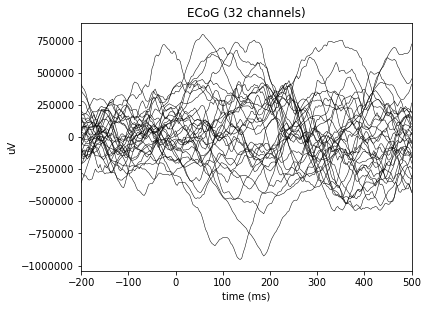

In [6]:
# Copy our raw data so it isn't overwritten, then rescale it to baseline.
ecog_av = ecog.copy()
mne.baseline.rescale(ecog_av._data, ecog.times, (-.8, -.1),
                     mode='zscore', copy=False)

# Average, crop, then plot the data
_ = ecog_av.average().crop(-.2, .5).plot()

This is relatively noisy because of the few numbers of trials, and the relatively low signal-to-noise ratio of raw electrode activity.

Fortunately, with ECoG we have the option to extract other features of the signal, which have different properties and may be more directly to stimulus information.

## High-frequency activity in the brain
For this tutorial, we will focus on "high-frequency amplitude" of the ECoG signal (sometimes called "high-gamma" amplitude). It essentially involves filtering out frequencies below ~70Hz, and calculating the envelope of the resulting signal. We will perform this with Morlet Wavelets.

### Morlet Wavelets
Before diving into the actual filtering, here is a quick primer of Morlet Wavelets. Basically, this is a short signal that oscillates at a particular frequency. The amplitude of the signal tapers off on both ends, so that it's highest in the middle and zero at the start/stop (it's actually a gaussian window which determines the amplitude of the signal). We can filter a timeseries with a wavelet like this, and it will allow us to extract the spectral energy that overlaps with that wavelet at each point in time.

Here are a few sample wavelets - we can use each of them to extract different frequency information from the signal:

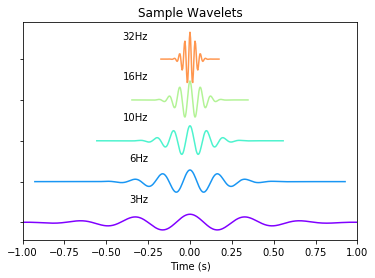

In [7]:
%matplotlib inline
# First we'll visualize a morlet wavelet:
fig, ax = plt.subplots()
wavelet_freqs=  [3, 6, 10, 16, 32]
cmap = plt.cm.rainbow
for ii, freq in enumerate(wavelet_freqs):
    wavelet = mne.time_frequency.morlet(ecog.info['sfreq'], [freq])[0]
    time = np.arange(len(wavelet)) / float(ecog.info['sfreq'])
    time -= time[len(time) // 2]
    color = cmap(float(ii) / len(wavelet_freqs))
    ax.plot(time, wavelet + .5 * ii, c=color)
    ax.text(-.25, .5 * ii + .25, '{}Hz'.format(freq), horizontalalignment='right')
    ax.set_xlim([-1, 1])
_ = plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel('Time (s)')
ax.set_title('Sample Wavelets')

### Using wavelets to filter our signal
Here we will extract high-frequency amplitude by using several band-pass filters with Morlet Wavelets. Each wavelet will extract a particular frequency band, and we will average each of them together to get a single time-varying high-frequency response. If we extract high-frequency activity, then we get a much cleaner signal.

Later on, we'll use the same procedure to generate a *spectrogram* of speech, which reveals the spectral information present in an auditory stimulus.

In [8]:
high_freq = ecog.copy()
freqs = np.logspace(np.log10(70), np.log10(140), 14)
etfr = mne.time_frequency.tfr_morlet(
    high_freq, freqs, picks=range(len(high_freq.ch_names)),
    n_cycles=freqs / 4., average=False, use_fft=True, return_itc=False)

# Now average across frequencies for a single time-varying amplitude
tfrs = etfr.data.mean(axis=2)

Applying baseline correction (mode: zscore)


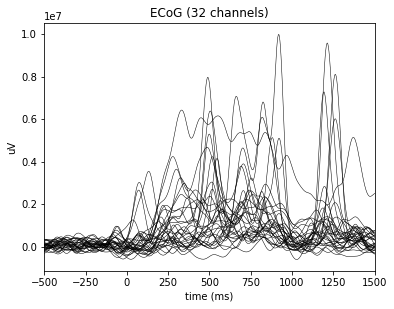

In [9]:
# We'll rescale the data so that it's in standard units above a baseline
high_freq._data = tfrs.copy()
_ = mne.baseline.rescale(high_freq._data, high_freq.times, (-.8, -.1),
                         mode='zscore', copy=False)

# Now plot
_ = high_freq.copy().crop(-.5, 1.5).average().plot()

As we can see above, the high-frequency amplitude of the signal seems to be much more time-locked to the onset of the stimulus. There is a clear increase in activity after time 0 (sound onset) that persists for some time.

We'll use this feature set for our models in the rest of the tutorial. However, note that it is possible to build an encoding model with many other neural features (e.g., power in other frequency bands).

In [10]:
# Now, resample to save computation time / space
high_freq.resample(sfreq_new, npad='auto')

# Save to disk
high_freq.save(save_path + 'hfa_ecog-epo.fif')

# Audio features
Now for our stimulus. As mentioned in the paper, the benefit of predictive modeling with naturalistic stimuli is that it's possible to use many different kinds of features belonging to the same stimulus set.

Below, we will cover a few common feature representations used in speech research. This is not an exhaustive list, but is meant to convey both the range of low- to high-level features, as well as the ways that different kinds of features (e.g., categorical vs. continuous) are coded as numeric variables.

## Raw audio
To begin with, we'll plot the raw data for our audio. This has already been cut into Epochs in order to save space. We'll plot the audio at each trial onset.

In [11]:
# If you'd like to use the following interactively, run this line
# Don't forget to run `%matplotlib inline` aftward
# %matplotlib notebook

Reading ../raw_data/audio-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1500.00 ...    6000.00 ms
        0 CTF compensation matrices available
29 matching events found
29 matching events found
0 projection items activated


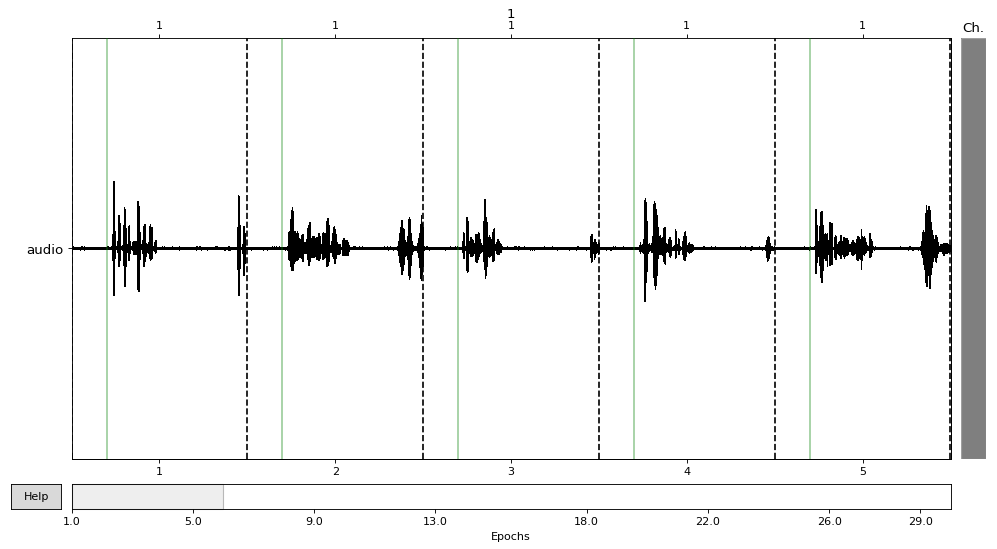

In [12]:
# We've already split our auditory data into a trials format, called Epochs
audio = mne.read_epochs(raw_path + 'audio-epo.fif', preload=True)

# We'll add a minimal amount of white noise so that we don't have zeros
audio._data += .1 * np.std(audio._data) * np.random.randn(*audio._data.shape)

# Now visualize
_ = audio.plot(picks=[0], scalings='auto', n_epochs=5)

Scrolling through these trials, we can see the type of audio being presented. We have ~30 trials of audio, each one a different spoken sentence. Note that in some cases, we can see the beginning of the next sentence in the tail end of the window for the current sentence. That's alright, as we'll be cutting out that data before fitting models anyway.

## Speech envelope
Perhaps the simplest representation of speech is its envelope. This is basically a description of when there is speech energy present in the sound. There are several ways to calculate this, but the simplest is to take the absolute value of the audio, then low-pass filter the result.

In [13]:
%matplotlib inline
# Take the absolute value, then low-pass filter
envelope = audio.copy()
envelope._data = np.abs(envelope._data)
envelope._data = mne.filter.filter_data(envelope._data,
                                        envelope.info['sfreq'],
                                        None,
                                        10, filter_length='1s')
envelope.resample(sfreq_new)

Setting up low-pass filter at 10 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Attenuation at stop frequency 12.5Hz is only 18.9dB. Increase filter_length for higher attenuation.


<EpochsFIF  |  n_events : 29 (all good), tmin : -1.5 (s), tmax : 5.995 (s), baseline : None, ~348 kB, data loaded>

Plotting the envelope, we can see that we now have a signal that is always positive, and shows how the overall amplitude of the speech changes.

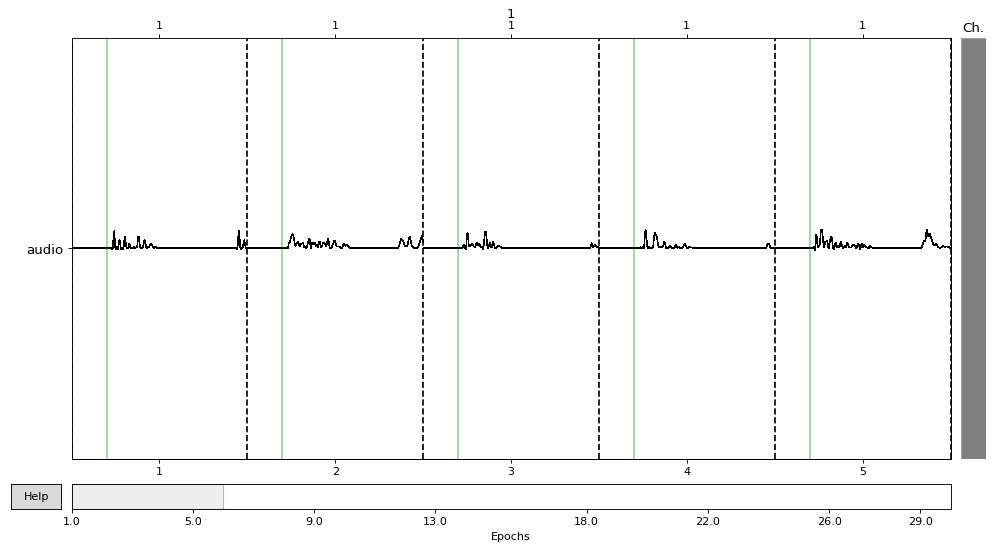

In [14]:
_ = envelope.plot(picks=[0], scalings='auto', n_epochs=5)

In [15]:
envelope.save(save_path + 'envelope-epo.fif')

## Spectrograms
The second most common representation of speech is the spectrogram. In this case, we represent the speech signal as a collection of sinusoidal waves, varying in frequency from low to high. We will calculate the extent to which each of these waves is present in the signal using a *morlet wavelet* transform. The output will tell us the spectral content present in the signal. To some extent, it is believed that this is similar to processing stages early in the auditory pathway (e.g., from the cochlea to the midbrain).

In [16]:
# We'll use log-spaced frequencies
frequencies = np.logspace(np.log10(300), np.log10(8000), 64)
n_decim = int(audio.info['sfreq'] // sfreq_new)

high_freq = ecog.copy()
freqs = np.logspace(np.log10(70), np.log10(140), 14)
tfrs = mne.time_frequency.tfr_morlet(
    audio, frequencies, picks=[0], n_cycles=frequencies / 4., average=False,
    use_fft=True, return_itc=False, decim=n_decim)

`tfrs` is now shape (n_epochs, n_frequencies, n_times). It is a time-frequency representation of each trial of audio.

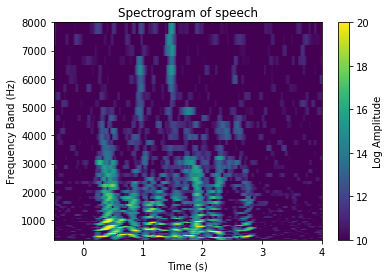

In [17]:
fig, ax = plt.subplots()

mask = mne.utils._time_mask(tfrs.times, -.5, 4)
plt_tfrs = tfrs.data[1].squeeze()[..., mask]
mesh = ax.pcolormesh(tfrs.times[mask], frequencies, np.log(plt_tfrs),
                     cmap='viridis', vmin=10, vmax=20)
ax.axis('tight')
ax.set_title('Spectrogram of speech')
ax.set_ylabel('Frequency Band (Hz)')
ax.set_xlabel('Time (s)')
cbar = fig.colorbar(mesh)
cbar.set_label('Log Amplitude')

The patterns of interest for this signal are visible as waves of higher intensity in the frequency range between 200 and 3000 Hz, and convey important perceptual information.

For example, the fundamental frequency of one's voice (aka F0 'formant' or 'pitch') is the lowest frequency at which there is power. It is also the distance between the horizontal traces (harmonics). It corresponds to the resonance of the vocal tract (a longer vocal tract has a lower resonance frequency).

This representation is called 'spectrogram' and represents the physical acoustic components of the language that we speak. Each horizontal "band" of power along the frequeny axis represents one frequency component (called Center Frequencies or CFs). We will save this feature set (= center frequencies of the spectrogram) so that we can fit spectro-temporal receptive fields (STRFs) further on.

In [18]:
# Now convert it to Epochs so we can use later
info_spec = mne.create_info(['{:.2f}'.format(ifreq) for ifreq in frequencies],
                            sfreq_new, 'misc')
tfrs = mne.EpochsArray(tfrs.data.squeeze(), info_spec, tmin=tfrs.times.min())

29 matching events found
0 projection items activated
0 bad epochs dropped


In [19]:
tfrs.save(save_path + 'spectrogram-epo.fif')

## Phonemes
Moving a little bit more in the abstract direction, we can also define speech in terms of linguistic features like phonemes. These are often described as the "building blocks" of language, and can be thought of as particular patterns in spectro-temporal space. If a region of the brain is more interested in these high-level features, then it will tend to respond to a subset of them more than others.

Phonemes do not have a number attached to each one *per se*. Instead, we will assign a categorical variable to each one. The variable is binary, with a `1` present if that phoneme is currently being heard. As such, there will only be a single `1` for each timepoint (though if we wanted to make things more complicated, we could include interactions between phonemes as well).

The TIMIT sentences have been transcribed for the timing and identity of each phoneme within a speech utterance. Here we will read in these timings from a text file and tidy them up so that they fit nicely into a pandas dataframe.

In [20]:
# Read in timing information
stimuli = pd.read_csv(raw_path + 'time_info.csv', index_col=0)
sfreq_timit = pd.read_csv(raw_path + 'meta_sub.csv')['sfreq_timit'].values[0]

# Loop through each phoneme, find its time onsets, and fill in 1s
phonemes = []
for ii, stim_name in enumerate(stimuli['stim_name']):
    stim_name = stim_name.replace('.wav', '')
    with open(raw_path + 'timit_word_info/text_info/{}.PHN'.format(stim_name, 'r')) as f:
        ph_sentence = f.readlines()
        ph_sentence = [jj.replace('\n', '').split(' ') for jj in ph_sentence]
        ph_sentence = pd.DataFrame(ph_sentence)
        ph_sentence['number'] = ii
        phonemes.append(ph_sentence)
phonemes = pd.concat(phonemes)
phonemes.columns = ['start', 'stop', 'phoneme', 'number']

# TIMIT timings are given in samples. Here we divide by sfreq to get seconds.
phonemes[['start', 'stop']] = phonemes[['start', 'stop']].apply(pd.to_numeric)
phonemes[['start', 'stop']] /= sfreq_timit

Now, we'll assign a unique integer to each phoneme (to create our categorical variables). Finally, we will loop through the phoneme timings and create dummy variables for each phoneme.

In [21]:
unique_phonemes = phonemes['phoneme'].unique()
phoneme_dict = {iph:ii for ii, iph in enumerate(unique_phonemes)}
phoneme_data = np.zeros([len(audio), len(unique_phonemes), len(tfrs.times)])

# Loop through phonemes and populate our binary data with its timings
for iep, isentence in phonemes.groupby('number'):
    for _, (istt, istp, iph, _) in isentence.iterrows():
        mask = mne.utils._time_mask(tfrs.times, istt, istp)
        phoneme_data[iep, phoneme_dict[iph], mask] = 1

# phoneme_dict tells us which row is associated w/ each phoneme
# This inserts the phoneme names into their proper place
phonemes_rev = dict((jj, ii) for ii, jj in phoneme_dict.items())
phonemes_labels = [phonemes_rev[ii] for ii in np.sort(list(phoneme_dict.values()))]

# Turn phoneme data into an EpochsArray for saving
info = mne.create_info(phonemes_labels, sfreq_new, 'misc')
phoneme_data = mne.EpochsArray(phoneme_data, info, tmin=tfrs.times.min())

29 matching events found
0 projection items activated
0 bad epochs dropped


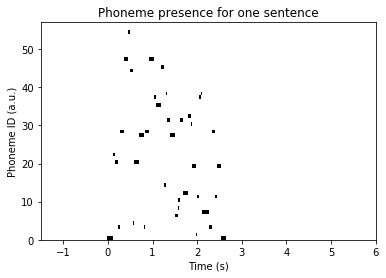

In [22]:
fig, ax = plt.subplots()
ax.pcolormesh(phoneme_data.times, range(len(unique_phonemes)),
              phoneme_data._data[10], cmap=plt.cm.Greys)
ax.set_ylabel('Phoneme ID (a.u.)')
ax.set_xlabel('Time (s)')
ax.set_title('Phoneme presence for one sentence')

As you can see, there are no overlapping timings between phonemes. Dark bars represent times at which the phoneme for that row is present. This is one way to code a categorical variable so that it may be used in model fitting.

In [23]:
phoneme_data.save(save_path + 'phonemes-epo.fif')

## Showing all at the same time
For encoding models, we will focus on using these three features as inputs. They roughly move from low-level to high-level, and should give an indication for how we'd use features like them to fit models. We'll plot all three for a single speech utterance below.

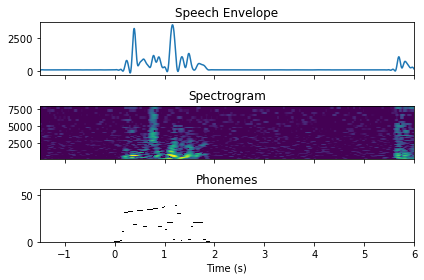

In [24]:
fig, axs = plt.subplots(3, 1, sharex=True)
ix = 2
# Plot the envelope
# Note that some values may be negative due to the filtering
axs[0].plot(envelope.times, envelope._data[ix][0])
axs[0].set_title('Speech Envelope')

# Plot the spectrogram
axs[1].pcolormesh(tfrs.times, frequencies, np.log(tfrs._data[ix]),
                  cmap=plt.cm.viridis, vmin=10, vmax=20)
axs[1].set_title('Spectrogram')

# Plot the phoneme labeling
axs[2].pcolormesh(tfrs.times, range(len(unique_phonemes)),
                  phoneme_data._data[ix], cmap=plt.cm.Greys)
axs[2].set_title('Phonemes')
axs[2].set_xlabel('Time (s)')
for ax in axs:
    ax.axis('tight')
plt.tight_layout()

## Epoching ECoG activity with labeled phonemes
Finally, in order to perform decoding we need to collect the ECoG activity in response to each phoneme. We can simply do this by epoching the ECoG data using the phoneme timings that we created above. We can then calculate the response of each electrode for each phoneme.

This will allow us to build a model with ECoG activity as an input, and a phoneme ID as an output. Note that this removes information about how the electrode activity changes across time, and instead summarizes each epoch with the mean activity per electrode in a short window after each phoneme (we'll do this in the `model fitting` notebook.

In [25]:
phone_lengths = np.sort(phonemes['stop'] - phonemes['start'])[::-1]

# We'll take a fixed window after each phoneme's onset
# The length of this window will be the mean length of all phonemes
time_keep_phone = np.mean(phone_lengths)
n_ixs_keep = int(time_keep_phone * high_freq.info['sfreq'])

In [26]:
# Finally, we'll create an Epoched version of *each* phoneme for classification
epochs_ph = []
for ii, phns in phonemes.groupby('number'):
    for _, (phst, phstp, phn, _) in phns.iterrows():
        ix_stt = int(phst * high_freq.info['sfreq'])
        i_mask_time = np.zeros(high_freq._data.shape[-1], dtype=bool)
        i_mask_time[ix_stt:ix_stt + n_ixs_keep] = True
        epochs_ph.append((phn, high_freq._data[ii][..., i_mask_time]))

phones, epochs_ph = zip(*epochs_ph)
phones = np.hstack(phones)
phones_labels = [phoneme_dict[ii] for ii in phones]
epochs_ph = np.stack(epochs_ph)

# Create an MNE representation of these event onsets.
events_phones = np.vstack([np.arange(len(phones_labels)),
                           np.zeros_like(phones_labels),
                           phones_labels]).T
# Now turn into an MNE object
epochs_phones = mne.EpochsArray(epochs_ph, high_freq.info, events_phones, event_id=phoneme_dict, tmin=0)

982 matching events found
0 projection items activated
0 bad epochs dropped


In this case we will have many more events than in the epochs plot we made above (one event for each phoneme, instead of one for each trial). However, they will be much shorter. We can still look at the average activity for each one (which won't look as clean because these phonemes aren't presented in a time-locked fashion)

In [27]:
epochs_phones

<EpochsArray  |  n_events : 982 (all good), tmin : 0.0 (s), tmax : 0.0733333333333 (s), baseline : None, ~5.6 MB, data loaded,
 'aa': 18, 'ae': 8, 'ah': 10, 'ao': 14, 'aw': 5, 'ax': 32, 'axr': 20, 'ay': 19, 'b': 22, 'bcl': 18, 'ch': 8, 'd': 18, 'dcl': 29, 'dh': 23, 'dx': 11, 'eh': 14, 'el': 8, 'en': 3, 'epi': 3, 'er': 16, 'ey': 22, 'f': 11, 'g': 9, 'gcl': 14, 'h#': 58, 'hh': 7, 'hv': 5, 'ih': 30, 'ix': 35, 'iy': 33, 'jh': 11, 'k': 24, 'kcl': 27, 'l': 30, 'm': 24, 'n': 32, 'ng': 7, 'nx': 4, 'ow': 9, 'oy': 2, 'p': 14, 'pau': 2, 'pcl': 11, 'q': 15, 'r': 33, 's': 39, 'sh': 8, 't': 31, 'tcl': 48, 'th': 3, 'uh': 4, 'uw': 5, 'ux': 15, 'v': 15, 'w': 15, 'y': 8, 'z': 21, 'zh': 2>

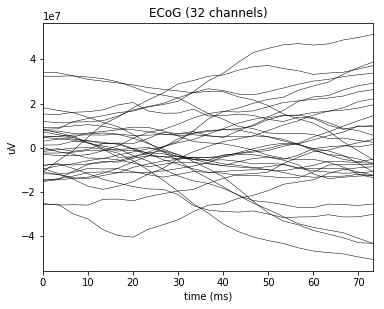

In [28]:
# It appears that some channels are responsive to this phoneme on average
_ = epochs_phones['aa'].average().plot()

In [29]:
epochs_phones.save(save_path + 'ecog_phonemes-epo.fif')

# Extra auditory features
Finally, we will describe a few other features here which are useful in modeling the neural response to speech features. We won't use them further in this tutorial, though they all pose interesting questions for neural computation and speech.

## Modulation power spectra (MPS)
The MPS is a useful description of a spectrogram. It describes to which there is energy in the spectrogram that repeats itself along frequency values (the y-axis) as well as along time (the x-axis). These are called spectral modulation, and rate modulation, respectively.

In practice, we can achieve the above description of a spectrogram with a 2-D fourier transform of the spectrogram, which we'll perform below. It is also common to convolve the spectrogram with many filters that fully span the spectral / rate modulation space.

Just as the brain builds higher-level features using information from low-level features, it is thought that the MPS may be represented in the brain as a kind of "pattern detection on spectrograms". However, there's still much work to be done in understanding its role.

In [30]:
# For labeling axes, what's the step between frequencies
freq_step_log = np.log(frequencies)
freq_step_log = freq_step_log[1] - freq_step_log[0]

# Calculate labels for our X and Y axes
mps_times = fftshift(fftfreq(tfrs.times.shape[0],
                             1. / tfrs.info['sfreq']))
mps_freqs = fftshift(fftfreq(frequencies.shape[0], freq_step_log))

In [31]:
# Loop through each epoch of our spectrograms and calculate the MPS
mps_all = []
for spec in tfrs:
    mps = fft2(spec)
    mps_all.append(np.abs(fftshift(mps)))
mps_all = np.array(mps_all)

We can plot the MPS of each spectrogram below. Here's one way to interpret it:

* If there is power near `(0, 0)` it means that the spectrogram has *very* smoothly varying patterns along both the time and frequency dimension.
* If there is power near either edge of the x-axis, it means that the spectrogram has very rapidly changing or oscillating energy along the time dimension (e.g., the sudden onset of a plosive).
* If there is power near the top of the plot, it means that the spectrogram has rapidly changing or oscillatory energy along the y-axis (e.g., the integer multiples of the fundamental frequency).
* Anything along the diagonals is some combination of both of these things.

Alternatively, each point in the MPS corresponds to calculating the amount of overlap in the spectrogram with each of the following filters:

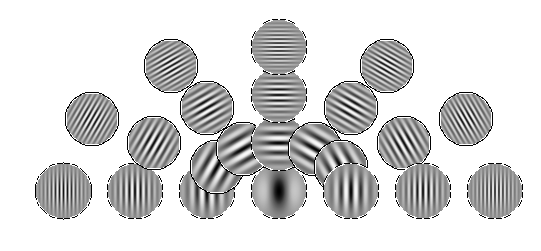

In [32]:
# We need to use inline plotting because this won't work interactively
%matplotlib inline
fig = plot_gabors_2d()

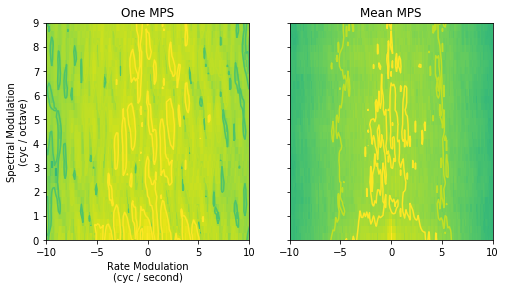

In [33]:
# Plot a sample MPS and the mean across all
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
for ax, mps_plt in zip(axs, [np.log(mps_all[0]), np.log(mps_all).mean(0)]):
    ax.pcolormesh(mps_times, mps_freqs, mps_plt, cmap='viridis')
    ax.contour(mps_times, mps_freqs, mps_plt,
               np.percentile(mps_plt, [80, 90, 95, 99]))
    _ = plt.setp(ax, xlim=[-10, 10], ylim=[0, 9])
axs[0].set_title('One MPS')
axs[1].set_title('Mean MPS')
axs[0].set_xlabel('Rate Modulation\n(cyc / second)')
axs[0].set_ylabel('Spectral Modulation\n(cyc / octave)')

## Words
Finally, we can go a step above phonemes and use word identities. The modeling becomes more complicated at this point, because there are *many* more possible words than possible phonemes, so we would need to collect much more data in order to properly model the brain's response to words in a naturalistic context. However, were we to use this feature set, it would look very similar to the way we've extracted phonemes above. Note that there are far more unique word IDs than there were for phonemes.

In [34]:
# Loop through words and tidy up each one's timing
words = []
for ii, stim_name in enumerate(stimuli['stim_name']):
    stim_name = stim_name.replace('.wav', '')
    with open(raw_path + 'timit_word_info/text_info/{}.WRD'.format(stim_name, 'r')) as f:
        w_sentence = f.readlines()
        w_sentence = [jj.replace('\n', '').split(' ') for jj in w_sentence]
        w_sentence = pd.DataFrame(w_sentence)
        w_sentence['number'] = ii
        words.append(w_sentence)
words = pd.concat(words)
words.columns = ['start', 'stop', 'word', 'number']

words[['start', 'stop']] = words[['start', 'stop']].apply(pd.to_numeric)
words[['start', 'stop']] /= sfreq_timit

In [35]:
# Now create a categorical variable for each word and populate with 1s
unique_words = words['word'].unique()
word_dict = {iph:ii for ii, iph in enumerate(unique_words)}
word_data = np.zeros([len(audio), len(unique_words), len(tfrs.times)])

for iep, isentence in words.groupby('number'):
    for _, (istt, istp, iph, _) in isentence.iterrows():
        mask = mne.utils._time_mask(tfrs.times, istt, istp)
        word_data[iep, word_dict[iph], mask] = 1

Here we can see that words behave much like phonemes for the purposes of modeling, but each one has much fewer repetitions (which is why we'd need to collect more data). Below you can see the speech envelope on top, and word presece on the bottom.

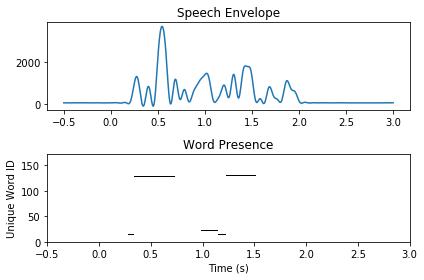

In [36]:
fig, axs = plt.subplots(2, 1)
mask_time = mne.utils._time_mask(envelope.times, -.5, 3)
ix = 20
axs[0].plot(envelope.times[mask_time],
            envelope._data[ix][0][..., mask_time])
axs[0].set_title('Speech Envelope')

axs[1].pcolormesh(envelope.times[mask_time], range(len(unique_words)),
                  word_data[ix][..., mask_time], cmap=plt.cm.Greys)
axs[1].set_title('Word Presence')
axs[1].set_ylabel('Unique Word ID')
axs[1].set_xlabel('Time (s)')
for ax in axs:
    ax.axis('tight')
plt.tight_layout()

## Unsupervised feature learning - Principle Components Analysis
While it is most straightforward to use feature representations that are based on our understanding of language or previous research on the brain, it is also possible to use statistial descriptions of stimulus features that summarize their properties or reduce its dimensionality.

For example, there are many methods to reduce a collection of features to a smaller number, while still retaining as much information as possible in the original features. This is called *dimensionality reduction*. This is useful because fewer dimensions generally means less chance of overfitting to data, and faster computation time. Importantly, the algorithm chosen for dimensionality reduction may also allow the researcher to gain insights into the relationships between features (and their relationship with the brain) that would have been much more difficult using the raw feature values.

Below we will show a common dimensionality reduction technique, known as Principle Components Analysis. This is a technique which aims to find new axis of the data that are orthogonal to one another, and that are sorted by their ability to capture the most to least amount of of variance in the data. Each axis is a linear combination of all other axes, so each can be thought of as some combination of the original feature values. It tends to show how subsets of features co-vary with one another, or if one variable is has a much larger amplitude than others.

In [37]:
# First we'll create delayed versions of the spectrogram.
# This lets us do PCA across patterns in both time and frequency.
delays = np.arange(0, -.4, -.02)
mask_time = mne.utils._time_mask(tfrs.times, 0, 4)

# We'll use the log of the data so frequencies are closer in amplitude
delayed = delay_time_series(np.log(tfrs._data), delays, tfrs.info['sfreq'])
delayed = delayed[..., mask_time]
delayed = delayed.reshape(delayed.shape[0], -1, delayed.shape[-1])
delayed = np.hstack(delayed)

In [38]:
# We'll use scikit-learn to extract the principle components of these features
# Scaling the data makes sure that PCs aren't dominated by amplitude differences
decomp = PCA()
decomposed = decomp.fit_transform(scale(delayed.T))

In PCA, we can plot the amount of variance that each component explains. It is common to throw away components that don't explain much variance, though there are many methods for determining which components to throw away. We'll just stick with plotting them in this tutorial.

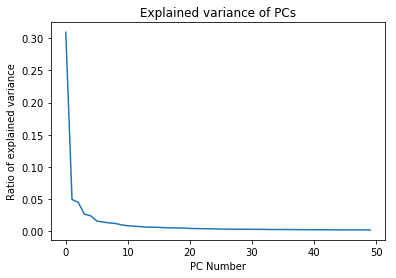

In [39]:
fig, ax = plt.subplots()
ax.plot(decomp.explained_variance_ratio_[:50])
ax.set_title('Explained variance of PCs')
ax.set_xlabel('PC Number')
ax.set_ylabel('Ratio of explained variance')

As you can see above, the first few principle components describe the largest amount of variance in the data. We can visualize how each PC is made up of a combination of the original features, and attempt to understand what patterns in the features that PC may represent.

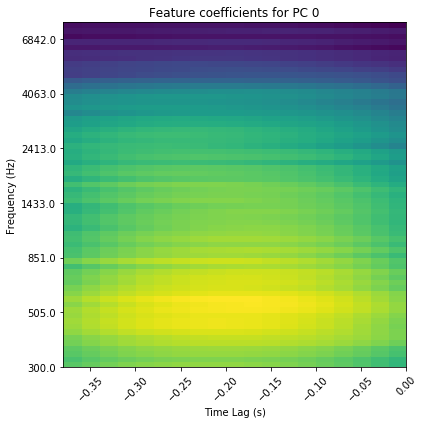

In [40]:
# Reshape the component weights so it's shape (n_frequencies, n_delays)
ix_component = 0
plt_component = decomp.components_[ix_component].reshape(-1, len(delays))

fig, ax = plt.subplots(figsize=(6, 6))
ax.pcolormesh(delays, np.log10(frequencies), plt_component,
              cmap=plt.cm.viridis)
ax.set_yticks(np.log10(frequencies)[::10])
ax.set_yticklabels(np.round(frequencies[::10]))
ax.axis('tight')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time Lag (s)')
ax.set_title('Feature coefficients for PC {}'.format(ix_component))
_ = plt.setp(ax.get_xticklabels(), rotation=45)
plt.tight_layout()

Whether the principle components have any actual meaning is anyone's guess, so it's important to use scientific intuition in order to interpret their meaning, rather than blindly putting PC values into a predictive model. For more information about feature decompositions such as dimensionality reduction, we recommend the Hastie textbook referenced in the paper. The documentation for scikit-learn is also a great resource for getting started.